## Import necessary modules

In [198]:
import time
import pandas as pd
import numpy as np
import datetime as dt
from collections import OrderedDict
from copy import copy
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
%matplotlib inline

## Filepath management

In [199]:
project_dir = r'/Users/hudson/Code/marketModel/'

## Load the data from the hdf store

In [200]:
stock_data = pd.read_hdf(project_dir + 'data/stock_data/raw_stock_data.hdf', 'table')
symbols = stock_data.reset_index().ticker.unique()
pprint(symbols)

array(['ASTC', 'PAVM', 'CODA', 'WSTL', 'MICR', 'SEAC', 'GBR', 'CPST',
       'CYAN', 'ATLC', 'WTT', 'LRAD', 'DTRM', 'AVIR', 'UTSI', 'JCS',
       'ZDGE', 'REFR', 'FORD', 'APHB', 'JVA', 'VSR', 'BNSO', 'ARDM', 'LEU',
       'MOC'], dtype=object)


In [201]:
stock_data.head()

open    high     low   close  volume
ticker timestamp                                                  
ASTC   2017-08-28 13:30:00  0.7500  0.7500  0.7500  0.7500     161
       2017-08-28 13:37:00  0.7500  0.7500  0.7500  0.7500     200
       2017-08-28 14:08:00  0.7700  0.7700  0.7700  0.7700     100
       2017-08-28 14:13:00  0.7523  0.7523  0.7523  0.7523     234
       2017-08-28 14:24:00  0.7700  0.7700  0.7700  0.7700     100

## Visualize the data

In [202]:
symbol = np.random.choice(symbols)
print 'symbol: ' + symbol
stock_data_vis = stock_data.loc[symbol]
print stock_data_vis.head()
print stock_data_vis.describe()

symbol: BNSO
                       open    high     low   close  volume
timestamp                                                  
2017-08-28 14:28:00  2.1550  2.1795  2.1550  2.1795     400
2017-08-28 14:31:00  2.1660  2.1660  2.1660  2.1660    1000
2017-08-28 16:13:00  2.1500  2.1500  2.1500  2.1500     400
2017-08-28 16:25:00  2.1400  2.1400  2.1400  2.1400     100
2017-08-28 18:27:00  2.1436  2.1436  2.1436  2.1436     120
            open       high        low      close       volume
count  83.000000  83.000000  83.000000  83.000000    83.000000
mean    2.170754   2.171746   2.169580   2.171096   392.289157
std     0.036060   0.035549   0.036088   0.035353   482.644179
min     2.090000   2.100000   2.090000   2.100000   100.000000
25%     2.149950   2.150000   2.146750   2.150000   150.000000
50%     2.160000   2.160000   2.160000   2.160000   200.000000
75%     2.194400   2.194400   2.194400   2.194400   400.000000
max     2.240000   2.240000   2.240000   2.240000  2973.000000


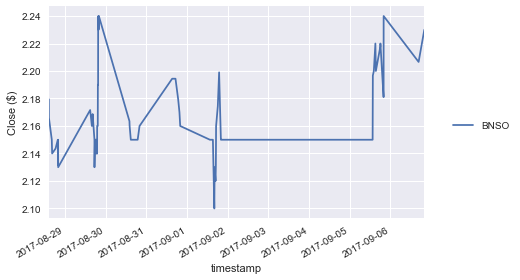

In [203]:
# First keep the time index so we can see the time frame
stock_data_vis.close.plot(label=symbol)

plt.legend(bbox_to_anchor=(1.25, .5))
plt.tight_layout()
plt.ylabel("Close ($)")
sns.despine()

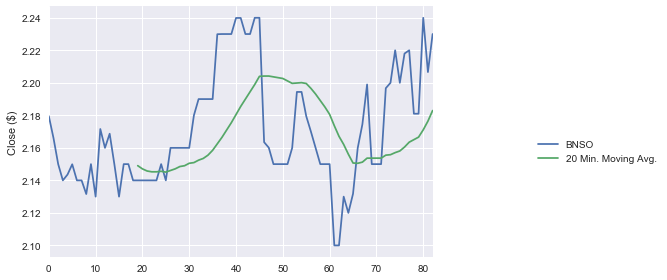

In [204]:
# Now drop the time index so we can see the actual stock movement
stock_data_vis.reset_index().close.plot(label=symbol)
stock_data_vis.reset_index().close.rolling(20).mean().plot(label='20 Min. Moving Avg.')

plt.legend(bbox_to_anchor=(1.25, .5))
plt.tight_layout()
plt.ylabel("Close ($)")
sns.despine()

## Adding in missing times (zero volume minutes)
Before evaluating goals, we need to fill in the missing time steps.
These missing time steps have zero trading volume.
So, all of the prices for these steps are equal to the last
closing price. All of the volumes are equal to zero.

In [205]:
# First reshape the index and group by ticker
stock_data_final = stock_data.reset_index(level=0)
print stock_data_final.head()
grouped_stock_data = stock_data_final.groupby('ticker')

                    ticker    open    high     low   close  volume
timestamp                                                         
2017-08-28 13:30:00   ASTC  0.7500  0.7500  0.7500  0.7500     161
2017-08-28 13:37:00   ASTC  0.7500  0.7500  0.7500  0.7500     200
2017-08-28 14:08:00   ASTC  0.7700  0.7700  0.7700  0.7700     100
2017-08-28 14:13:00   ASTC  0.7523  0.7523  0.7523  0.7523     234
2017-08-28 14:24:00   ASTC  0.7700  0.7700  0.7700  0.7700     100


In [209]:
## Before evaluating goals, we need to fill in the missing time steps.
## These missing time steps have zero trading volume.
## So, all of the prices for these steps are equal to the last
## closing price. All of the volumes are equal to zero.

stock_data_with_all_minutes = []
for name, group in grouped_stock_data:
    
    # Create a dataframe of all the times
    min_time, max_time = group.index.min(), group.index.max()    
    duration = (min_time - max_time).seconds / 60
    alltimes = pd.DataFrame([min_time + np.timedelta64(i, 'm') for i in xrange(duration)], columns=['timestamp'])
    alltimes = alltimes.reset_index(level=0, drop=True).set_index('timestamp')
    
    # Drop minutes outside of 9:30am - 4:00pm est
    alltimes = alltimes.between_time('09:30','16:00')
  
    # Join on the original dataframe
    alltimes_group = alltimes.join(group)
    
    # Forward fill the NaN closing prices 
    alltimes_group.loc[:,('ticker', 'close')] = alltimes_group.loc[:,('ticker', 'close')].\
                                                    fillna(method='ffill', axis=0)
    
    # Assign all price variables to the close price
    alltimes_group.loc[:,'open':'close'] = alltimes_group.loc[:,'open':'close'].\
                                                fillna(method='bfill', axis=1)
    
    # Assign all NaN volumes to zero
    alltimes_group.loc[:, 'volume'] = alltimes_group.loc[:, 'volume'].fillna(value=0)
    
    stock_data_with_all_minutes.append(alltimes_group)
    
stock_data_with_all_minutes = pd.concat(stock_data_with_all_minutes)


In [213]:
stock_data_with_all_minutes.reset_index().loc[:,('ticker', 'timestamp')].groupby('ticker').agg([np.min,np.max])

timestamp                    
                      amin                amax
ticker                                        
APHB   2017-08-28 13:30:00 2017-08-28 16:00:00
ARDM   2017-08-28 13:30:00 2017-08-28 16:00:00
ASTC   2017-08-28 13:30:00 2017-08-28 16:00:00
ATLC   2017-08-28 13:30:00 2017-08-28 16:00:00
AVIR   2017-08-28 13:30:00 2017-08-28 16:00:00
BNSO   2017-08-28 14:28:00 2017-08-28 16:00:00
CODA   2017-08-28 13:30:00 2017-08-28 16:00:00
CPST   2017-08-28 13:30:00 2017-08-28 16:00:00
CYAN   2017-08-28 13:33:00 2017-08-28 16:00:00
DTRM   2017-08-28 13:35:00 2017-08-28 16:00:00
FORD   2017-08-28 13:30:00 2017-08-28 16:00:00
GBR    2017-08-28 13:30:00 2017-08-28 16:00:00
JCS    2017-08-28 13:30:00 2017-08-28 16:00:00
JVA    2017-08-28 14:01:00 2017-08-28 16:00:00
LEU    2017-08-28 13:40:00 2017-08-28 16:00:00
LRAD   2017-08-28 13:30:00 2017-08-28 16:00:00
MICR   2017-08-28 14:57:00 2017-08-29 09:54:00
MOC    2017-08-28 15:28:00 2017-08-29 10:55:00
PAVM   2017-08-28 13:30:00 2017-08-28 16:00:00
REFR   2017-08-28 13:30:00 2017-08-28 16:00:00
SEAC   2017-08-28 13:30:00 2017-08-28 16:00:00
UTSI   2017-08-28 13:30:00 2017-08-28 16:00:00
VSR    2017-08-28 13:30:00 2017-08-28 16:00:00
WSTL   2017-08-28 13:30:00 2017-08-28 16:00:00
WTT    2017-08-28 14:02:00 2017-08-28 16:00:00
ZDGE   2017-08-28 13:51:00 2017-08-28 16:00:00

## Logic for getting goal information

In [179]:
def get_min_max(data, starttime, endtime):
    """
    This function takes data for a specific ticker and returns the min and max prices.
    """
    subdata = data.loc[starttime:endtime]
    
    return (subdata.low.min(), subdata.high.max())
    
def is_goal_met(data, timestep, goal_time_from_step, goal_duration, goal_raise_frac = 0.1, goal_drop_frac=0.1):
    """
    This function takes data for a specific ticker, a time index for that ticker, goal parameters, and 
    returns a boolean indicating whether or not the goal is satisfied for that timestep.
    """
    
    # Assign a status message to record various special cases
    statusMessage = ""
    
    # Convert time variables to appropriate numpyt date types
    td_goal_time_from_step = np.timedelta64(goal_time_from_step, 'm')
    td_goal_duration = np.timedelta64(goal_duration, 'm')
    
    # Calculate the start and end times of the goal time window
    goal_starttime = np.datetime64(timestep + td_goal_time_from_step)
    goal_endtime = np.datetime64(goal_starttime + td_goal_duration)
    
    if goal_endtime > np.datetime64(data.index.max()):
        statusMessage = "Goal time window end time lies beyond available data."
    
    # Get the data for goal checking in that time window
    subdata = data.loc[goal_starttime:goal_endtime]
    
    # Get the minimum and maximum prices for the goal time window
    min_price, max_price = get_min_max(data, goal_starttime, goal_endtime)
    if np.isnan(min_price) | np.isnan(max_price):
        # Zero trading volume in time window. Get last prices.
        most_recent_time_with_transactions = np.max(data.loc[:goal_starttime].index)
        if most_recent_time_with_transactions == timestep:
            statusMessage = statusMessage + " Zero trading volume between current timestep and goal time window end."
            return {'timestamp': timestep,
                    'goal_met': False,
                    'raise_goal_met': False,
                    'drop_goal_met': True,
                    'statusMessage': statusMessage}
        else:
            min_price, max_price = data.loc[timestep, 'low'], data.loc[timestep, 'high']
        
        
    # Determine if goals were met
    # TODO: is this the right reference for the 'current price'?
    current_price = np.mean(data.loc[timestep, ['high', 'close']])
    
    # Is raise goal met? Return true if max price at least (1+goal_raise_frac) * current_price
    is_raise_goal_met = max_price >= (1+goal_raise_frac) * current_price
    
    # Is drop goal met? Return true if min price at least (1-goal_drop_frac) * current_price
    is_drop_goal_met = min_price >= (1-goal_drop_frac) * current_price
    
    # Return dict containing raise and drop goals and product for convenience
    return {'timestamp': timestep,
        'goal_met': is_raise_goal_met * is_drop_goal_met, 
            'raise_goal_met': is_raise_goal_met, 
            'drop_goal_met': is_drop_goal_met,
             'statusMessage': statusMessage}

In [180]:
# test get_min_max
get_min_max(stock_data_vis, '2017-08-28', '2017-08-30')

(2.1299999999999999, 2.2400000000000002)

In [181]:
# test is_goal_met
random_time_index = np.random.choice(stock_data_vis.index.values)
print "Random time: " + str(random_time_index)
is_goal_met(stock_data_vis, random_time_index, 0, 1000)

Random time: 2017-08-16T17:49:00.000000000


{'drop_goal_met': True,
 'goal_met': False,
 'raise_goal_met': False,
 'statusMessage': '',
 'timestamp': numpy.datetime64('2017-08-16T17:49:00.000000000')}

## Get goal tags for all data

In [182]:
# first define a function that tags for one ticker
def get_tagged_stock_data(data, 
                          ticker, 
                          goal_time_from_step, 
                          goal_duration, 
                          goal_raise_frac = 0.1, 
                          goal_drop_frac=0.1):
    # Loop over the timestamps building a dictionary of the tagging information
    tagged_stock_data = []
    for timestep in data.index:
        goal_dict = is_goal_met(data, timestep, goal_time_from_step, goal_duration, goal_raise_frac, goal_drop_frac)
        tagged_stock_data.append(goal_dict)
    # Convert to pandas and return
    return pd.DataFrame(tagged_stock_data).set_index('timestamp')

In [183]:
start_delay = 24*60 # minutes
duration = 24*60*3 # minutes
raise_fraction = 0.05
drop_fraction = 0.05
list_tagged_tickers = []
for symbol, group in stock_data_with_all_minutes.groupby('ticker'):
    print symbol
    
    # get the tag data for this symbol
    tag_data = get_tagged_stock_data(group, symbol, start_delay, duration, raise_fraction, drop_fraction)
    
    # join tag data back onto the group data
    merged_data = group.join(tag_data)
    
    # Append to the list of tagged data
    list_tagged_tickers.append(merged_data)
    
# Concatenate all the groups
all_tagged_data = pd.concat(list_tagged_tickers)

APHB
ARDM
ASTC
ATLC
AVIR
BNSO
CODA
CPST
CYAN
DTRM
FORD
GBR
JCS
JVA
LEU
LRAD
MICR
MOC
PAVM
REFR
SEAC
UTSI
VSR
WSTL
WTT
ZDGE


In [184]:
print all_tagged_data.head()

                    ticker    open    high     low   close  volume  \
timestamp                                                            
2017-08-08 13:30:00   APHB  0.8200  0.8200  0.8200  0.8200  3478.0   
2017-08-08 13:31:00   APHB  0.8200  0.8200  0.8200  0.8200     0.0   
2017-08-08 13:32:00   APHB  0.8224  0.8224  0.8224  0.8224   320.0   
2017-08-08 13:33:00   APHB  0.8224  0.8224  0.8224  0.8224     0.0   
2017-08-08 13:34:00   APHB  0.8224  0.8224  0.8224  0.8224     0.0   

                     drop_goal_met  goal_met  raise_goal_met  \
timestamp                                                      
2017-08-08 13:30:00           True     False           False   
2017-08-08 13:31:00           True     False           False   
2017-08-08 13:32:00           True     False           False   
2017-08-08 13:33:00           True     False           False   
2017-08-08 13:34:00           True     False           False   

                                                         sta

In [185]:
print all_tagged_data.goal_met.value_counts()
print all_tagged_data.statusMessage.value_counts()

False    3077
Name: goal_met, dtype: int64
Goal time window end time lies beyond available data.                                                                           3051
Goal time window end time lies beyond available data. Zero trading volume between current timestep and goal time window end.      26
Name: statusMessage, dtype: int64


## Save data to hdf

In [76]:
all_tagged_data.to_hdf(project_dir + 'data/stock_data/tagged_stock_data.hdf', 'table')